In [275]:
import keras
import numpy as np
import tensorflow as tf
from tqdm import tqdm


In [3]:
%conda install regex

Solving environment: | 
The environment is inconsistent, please check the package plan carefully
The following packages are causing the inconsistency:

  - defaults/linux-64::pandas==1.0.1=py36h0573a6f_0
  - defaults/noarch::jupyterlab==1.2.6=pyhf63ae98_0
  - defaults/linux-64::scikit-learn==0.22.1=py36hd81dba3_0
  - defaults/linux-64::python-language-server==0.31.7=py36_0
  - defaults/linux-64::bkcharts==0.2=py36_0
  - defaults/linux-64::nb_conda==2.2.1=py36_0
  - defaults/noarch::numpydoc==0.9.2=py_0
  - defaults/linux-64::pytest-arraydiff==0.3=py36h39e3cac_0
  - defaults/linux-64::bottleneck==1.3.2=py36heb32a55_0
  - defaults/noarch::sphinx==2.4.0=py_0
  - defaults/linux-64::pywavelets==1.1.1=py36h7b6447c_0
  - defaults/noarch::pytest-astropy==0.8.0=py_0
  - defaults/linux-64::numexpr==2.7.1=py36h423224d_0
  - defaults/noarch::anaconda-project==0.8.4=py_0
  - defaults/linux-64::nbconvert==5.6.1=py36_0
  - defaults/linux-64::h5py==2.10.0=py36h7918eee_0
  - defaults/linux-64::bokeh==1

# Prepare data

In [276]:
import unicodedata
import regex as re

def normalize_text(text):
    clean_text=text.lower()
    clean_text=re.sub(r"[^a-zA-Z0-9\säåö]"," ",clean_text)
    #clean_text=re.sub(r"[^\S\n]+"," ",clean_text)
    clean_text=re.sub(r"\s+"," ",clean_text)
    clean_text=re.sub(r"^\s","",clean_text)
    clean_text=re.sub(r"\s$","",clean_text)
    return clean_text

normalize_text("äåöjkjh jhjk j1hkj"),normalize_text("jFjh.jhjk,.,.ef jhkj "),normalize_text(" jkjh jhjk jhkj")

('äåöjkjh jhjk j1hkj', 'jfjh jhjk ef jhkj', 'jkjh jhjk jhkj')

In [346]:
import csv
finnish_company_names=[]
with open('fullprhdata.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=';')
    for row in csv_reader:
        finnish_company_names.append(row[0])
json.dump(finnish_company_names,open("finnish_registry_companies.json","w+"))

In [347]:
import json 
import random
finnish_companies = json.load(open("finnish_registry_companies.json","r+"))
all_companies = json.load(open("all_kaggle_companies.json","r+"))

# companies 
names_arr=[normalize_text(company) for company in tqdm(all_companies)]
random.shuffle(names_arr)
names_text="\n".join(names_arr)

# finnish 
finnish_names_arr=[normalize_text(company) for company in tqdm(finnish_companies)]
random.shuffle(finnish_names_arr)
finnish_names_text="\n".join(finnish_names_arr)


characters=sorted(list(set(names_text+finnish_names_text)))
characters="."+characters # . is none
char_indices = dict((c, i) for i, c in enumerate(characters))
indices_char = dict((i, c) for i, c in enumerate(characters))

Tx=25





  0%|          | 0/7173427 [00:00<?, ?it/s]


  0%|          | 5540/7173427 [00:00<02:09, 55391.73it/s]


  0%|          | 10852/7173427 [00:00<02:10, 54688.35it/s]


  0%|          | 16124/7173427 [00:00<02:12, 54080.02it/s]


  0%|          | 21478/7173427 [00:00<02:12, 53915.96it/s]


  0%|          | 26802/7173427 [00:00<02:13, 53708.60it/s]


  0%|          | 32164/7173427 [00:00<02:13, 53681.01it/s]


  1%|          | 37589/7173427 [00:00<02:12, 53848.97it/s]


  1%|          | 43019/7173427 [00:00<02:12, 53980.97it/s]


  1%|          | 48576/7173427 [00:00<02:10, 54446.28it/s]


  1%|          | 54021/7173427 [00:01<02:10, 54445.23it/s]


  1%|          | 59526/7173427 [00:01<02:10, 54623.30it/s]


  1%|          | 64880/7173427 [00:01<02:10, 54289.73it/s]


  1%|          | 70273/7173427 [00:01<02:11, 54180.55it/s]


  1%|          | 75791/7173427 [00:01<02:10, 54475.31it/s]


  1%|          | 81296/7173427 [00:01<02:09, 54643.83it/s]


  1%|          | 86756/7173427 [00:01

KeyboardInterrupt: 




  2%|▏         | 146478/7173427 [00:18<02:11, 53339.01it/s]

In [ ]:
print("Characters:","".join(characters))
print("Chars: ",len(characters))
print("Tx: ",Tx)

In [ ]:
def str_to_vec(word, start_with_null=False):
    """
    Converts word to vec
    
    word -- string
    
    returns array of shape (Tx, len(chars))
    """
    if start_with_null:
        word="."+word
    x = np.zeros((len(word), len(characters)), dtype=np.bool)
    for t, char in enumerate(word):
        x[t, char_indices[char]] = 1
    return x
    
def vec_to_str(vec):
    """
    Converts vec to word
    
    vec -- array of shape (Tx, len(chars))
    
    """
    word=""
    for i in range(vec.shape[0]):
        word+=indices_char[np.argmax(vec[i])]
    return word

a=str_to_vec("hello world",start_with_null=True)
#print(a)
print(vec_to_str(a))

In [ ]:
def vectorization(text, stride, n_x, Tx):
    """
    Convert X and Y (lists) into arrays to be given to a recurrent neural network.
    
    Arguments:
    X -- 
    Y -- 
    Tx -- integer, sequence length
    
    Returns:
    x -- array of shape (m, Tx, len(chars))
    y -- array of shape (m, Tx, len(chars))
    """
    
    m = int((len(text)-Tx-1)/stride)
    x = np.zeros((m, Tx, n_x), dtype=np.bool)
    y = np.zeros((m, Tx, n_x), dtype=np.bool)
    
    for t, i in enumerate(tqdm(range(0,m*stride,stride))):
        fragment=text[i:i+Tx]
        pred=text[i+1:i+Tx+1]
        x[t, :, :] = str_to_vec(fragment)
        y[t,:, :] = str_to_vec(pred)
        
    return x, y 

X,Y=vectorization(names_text, 10, n_x=len(characters), Tx=Tx)
Xf,Yf=vectorization(finnish_names_text, 10, n_x=len(characters), Tx=Tx)
X.shape, Y.shape, Xf.shape, Yf.shape, 

In [ ]:
id_=3430
vec_to_str(Xf[id_]),vec_to_str(np.array(Yf[id_]))

# Model

In [84]:
def sample(preds, temperature=1.0):
    # helper function to sample an index from a probability array
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    out = np.random.choice(range(len(characters)), p = probas.ravel())
    out=characters[out]
    return out

def generate_output(model, text_start, length=5):
    
    for diversity in [0.2, 0.5, 1.0, 1.2]:
        print(f"Diversity: {diversity}")
        for l in range(length):
            generated = '\n'
            sentence = ('{0:\n>' + str(Tx) + '}').format(text_start).lower()
            generated += text_start 
            gens=0

            generated = ""
            inp=text_start
            sentence = inp

            x_pred = np.zeros((1, Tx, len(characters)))
            for t, char in enumerate(sentence):
                x_pred[0, t, char_indices[char]] = 1.0
            preds = model.predict(x_pred, verbose=0)[0]
            for pred in preds:
                next_index = sample(pred)
                next_char = next_index
                sentence = sentence + next_char
                generated += next_char
            print(f"{inp}{generated}")
        
generate_output(model,"accent")

Diversity: 0.2
accentdoenseo aeptsuieiunsalotwitnouta
accentpkc tslss o ustrtsau itao urt  v
accent3h stela tlyaiaautseepraa midptc
accentblh fipoeea be1niutttsgtalolnsde
accentlsestef sc eipeiysreysuiteo tspt
Diversity: 0.5
accenttlurtioldce tasiat ucoitfayaw ui
accentpcuntrragia i rksctiaa ftaai ena
accentcioätes g lysift toiiopiuiethtii
accentiteltec eet  n  smmrtoonyugudtoa
accenttaamtol  iaolel toayt esu vtitua
Diversity: 1.0
accentmgelliouya esyilannf oyos iyyrte
accentq obtelsl scsyai  uwabyua oitgit
accentroordhoviisaaptlawvusyn ctoelaao
accentw oxteiyreioaasatpauut ecxaecf s
accentkoorte   m sytsa soe caisay  eso
Diversity: 1.2
accentdrorcuy aire islcfistattouaulatt
accentwpemteea bi iayisiesg ogttti csm
accent1yyrt r l s tcpiifttsionaepotivt
accentmotttea latyesossrusryacoi tirtt
accentyooxtea sumumroilecat eetfaaumpa


In [25]:
from keras import layers, models
from keras.layers import Dense, Input, LSTM,GRU

drp=0
model=models.Sequential()
model.add(LSTM(128, input_shape=(Tx, len(characters)),return_sequences=True))
model.add(Dense(len(characters),activation="softmax"))
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 25, 128)           87040     
_________________________________________________________________
dense_6 (Dense)              (None, 25, 41)            5289      
Total params: 92,329
Trainable params: 92,329
Non-trainable params: 0
_________________________________________________________________


In [26]:
from keras.callbacks import LambdaCallback

def on_epoch_end(epoch, logs):
    generate_output(model,"acc")

print_callback = LambdaCallback(on_epoch_end=on_epoch_end)


In [ ]:
model.compile(loss='categorical_crossentropy', optimizer="adam")

history=model.fit(X, Y, batch_size=4096, validation_split=0.1,  epochs=100, shuffle=True, callbacks=[print_callback])

Train on 13813600 samples, validate on 1534845 samples
Epoch 1/100
13813600/13813600 [==============================] - 659s 48us/step - loss: 2.0369 - val_loss: 1.8503
===Diversity: 0.2 ===
accthtklheti taihcgrit peelc
===Diversity: 0.5 ===
accncye tbirialeaierhs  utlb
===Diversity: 1.0 ===
acclkeutae8lvk e rigiiolvoas
===Diversity: 1.2 ===
accneodoiamildaa ifiuorhtic 
Epoch 2/100
13813600/13813600 [==============================] - 655s 47us/step - loss: 1.8073 - val_loss: 1.7804
===Diversity: 0.2 ===
accnteumteih piho rciirisdet
===Diversity: 0.5 ===
acc tedacezailtotiannaryoe
i
===Diversity: 1.0 ===
acc veunsiirlltm
 udctp isgv
===Diversity: 1.2 ===
accsoautrgbfr aroieaiegeiirj
Epoch 3/100
13813600/13813600 [==============================] - 657s 48us/step - loss: 1.7636 - val_loss: 1.7532
===Diversity: 0.2 ===
acc tluua azasiimsiaryaet
im
===Diversity: 0.5 ===
accckoddo eaminilrihssteairi
===Diversity: 1.0 ===
acc t ssiui iazvtveamestwazs
===Diversity: 1.2 ===
accliosrjestdat jisl

KeyboardInterrupt: 

In [70]:
model.save("alltext.hdf5")

# Per name model

In [349]:
import json 
import random
#finnish_companies = json.load(open("finnish_kaggle_companies.json","r+"))

Tx=15

# finnish 
finnish_names_arr=[normalize_text(company) for company in finnish_companies if len(company)<Tx]
random.shuffle(finnish_names_arr)
finnish_names_text="".join(finnish_names_arr)

# all companies 
#names_arr=[normalize_text(company) for company in all_companies if len(company)<Tx]
#random.shuffle(names_arr)
#names_arr=random.choices(names_arr,k=int(len(finnish_names_arr)))
#finnish_names_arr+=names_arr


characters=sorted(list(set(finnish_names_text)))
characters=[".","E"]+characters # . is none, E is end of line
char_indices = dict((c, i) for i, c in enumerate(characters))
indices_char = dict((i, c) for i, c in enumerate(characters))

print(len(finnish_names_arr))
print("\n".join(random.choices(finnish_names_arr,k=10)))

103139
reilamex oy
kalakaapu oy
metlab oy
vuorinvest oy
martinkari oy
sähköjänis oy
oy klismos ab
leka global oy
bosom oy
vhl huolto oy


In [350]:
def vectorization(words, n_x, Tx=None):
    """
    Convert X and Y (lists) into arrays to be given to a recurrent neural network.
    
    Arguments:
    X -- 
    Y -- 
    Tx -- integer, sequence length
    
    Returns:
    x -- array of shape (m, Tx, len(chars))
    y -- array of shape (m, Tx, len(chars))
    """
    if Tx is None:
        Tx=len(max(words,key=len))
        print(Tx)
    
    m = len(words)
    x = np.zeros((m, Tx, n_x), dtype=np.bool)
    y = np.zeros((m, Tx, n_x), dtype=np.bool)
    
    for w, word in enumerate(tqdm(words)):
        word=word[:Tx]
        x[w, 0:len(word)+1, :] = str_to_vec(word,start_with_null=True)
        x[w, len(word)+1:, char_indices["E"]] = 1
        
        y[w, 0:len(word),:] = str_to_vec(word)
        y[w, len(word):, char_indices["E"]] = 1
        
    return x, y 

Xf,Yf=vectorization(finnish_names_arr, n_x=len(characters), Tx=Tx)
Xf.shape, Yf.shape 





  0%|          | 0/103139 [00:00<?, ?it/s]



  6%|▌         | 6122/103139 [00:00<00:01, 61212.91it/s]



 12%|█▏        | 12813/103139 [00:00<00:01, 62812.49it/s]



 19%|█▉        | 19591/103139 [00:00<00:01, 64222.02it/s]



 26%|██▌       | 26564/103139 [00:00<00:01, 65780.45it/s]



 32%|███▏      | 33042/103139 [00:00<00:01, 65474.22it/s]



 39%|███▊      | 39763/103139 [00:00<00:00, 65983.77it/s]



 45%|████▌     | 46559/103139 [00:00<00:00, 66562.71it/s]



 52%|█████▏    | 53492/103139 [00:00<00:00, 67368.32it/s]



 58%|█████▊    | 59885/103139 [00:00<00:00, 64481.81it/s]



 65%|██████▍   | 66742/103139 [00:01<00:00, 65654.73it/s]



 72%|███████▏  | 73798/103139 [00:01<00:00, 67051.96it/s]



 78%|███████▊  | 80841/103139 [00:01<00:00, 68027.67it/s]



 85%|████████▌ | 87932/103139 [00:01<00:00, 68867.34it/s]



 92%|█████████▏| 94973/103139 [00:01<00:00, 69322.96it/s]



100%|██████████| 103139/103139 [00:01<00:00, 67376.91it/s]


((103139, 15, 42), (103139, 15, 42))

In [436]:

print(vec_to_str(Xf[11324])),
print(vec_to_str(Yf[11324]))

.ninra oyEEEEEE
ninra oyEEEEEEE


In [537]:
def make_name(model, beginning=""):
    name = beginning
    x = np.zeros((1, Tx, len(characters)))
    x[0,0:len(beginning),:]=str_to_vec(beginning)
    
    for i in range(len(beginning)-1,Tx-1):
        prediction=model.predict(x)[0]
        probs = list(prediction[i])
        probs = probs / np.sum(probs)
        index = np.random.choice(range(len(characters)), p=probs)
        #index = np.argmax(probs)
        character = indices_char[index]
        print(f"{vec_to_str(x[0])} -> {vec_to_str(prediction)} -> {character}")
        if character=="E":
            break
        name+=character
        x[0, i+1, index] = 1

        i += 1
    
    print(name)

for i in range
make_name(model,"kyrpä")

kyrpä.......... -> elää rktoaEEEEE -> k
kyrpäk......... -> elää iioaaEEEEE -> i
kyrpäki........ -> elää i tooEEEEE -> v
kyrpäkiv....... -> elää i eooEEEEE -> o
kyrpäkivo...... -> elää i e  aEEEE ->  
kyrpäkivo ..... -> elää i e obEEEE -> o
kyrpäkivo o.... -> elää i e oyEEEE -> y
kyrpäkivo oy... -> elää i e oyEEEE -> E
kyrpäkivo oy


In [538]:
from keras import layers, models
from keras.layers import Dense, Input, LSTM,GRU

drp=0
model=models.Sequential()
model.add(LSTM(64, input_shape=(Tx, len(characters)),return_sequences=True))
model.add(Dense(len(characters),activation="softmax"))
model.summary()

Model: "sequential_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_33 (LSTM)               (None, 15, 64)            27392     
_________________________________________________________________
dense_31 (Dense)             (None, 15, 42)            2730      
Total params: 30,122
Trainable params: 30,122
Non-trainable params: 0
_________________________________________________________________


In [370]:
from keras.callbacks import LambdaCallback

def on_epoch_end(epoch, logs):
    for i in range(3):
        make_name(model)
        
print_callback = LambdaCallback(on_epoch_end=on_epoch_end)


In [408]:
opt=keras.optimizers.Adam(learning_rate=0.0001)

model.compile(loss='categorical_crossentropy', optimizer="adam")

history=model.fit(Xf, Yf, batch_size=8192, validation_split=0.1,  epochs=1000, shuffle=True, callbacks=[print_callback],verbose=1)

Train on 92825 samples, validate on 10314 samples
Epoch 1/1000
92825/92825 [==============================] - 2s 25us/step - loss: 2.0997 - val_loss: 2.0806
t8oese ra boa
ä3a0 opy duo 
zl0kef
Epoch 2/1000
92825/92825 [==============================] - 2s 17us/step - loss: 2.0622 - val_loss: 2.0439
göcmari al oo
7arxs yy
xje nuont moo
Epoch 3/1000
92825/92825 [==============================] - 2s 17us/step - loss: 2.0279 - val_loss: 2.0106
hwl1ötn of
ä7sd7aaal mlyy
drmamapo ox
Epoch 4/1000
92825/92825 [==============================] - 2s 17us/step - loss: 1.9954 - val_loss: 1.9789
3
özaor s  yy
pmkinno wi 
Epoch 5/1000
92825/92825 [==============================] - 2s 17us/step - loss: 1.9639 - val_loss: 1.9479
m5ioiilayl
bnlvuotarayoy
jtesa3rea  
Epoch 6/1000
92825/92825 [==============================] - 2s 17us/step - loss: 1.9330 - val_loss: 1.9172
j4e oöiruayvoy
pcvakopoiycy
viia9kcoucay 
Epoch 7/1000
92825/92825 [==============================] - 2s 17us/step - loss: 1.9025 - val

KeyboardInterrupt: 

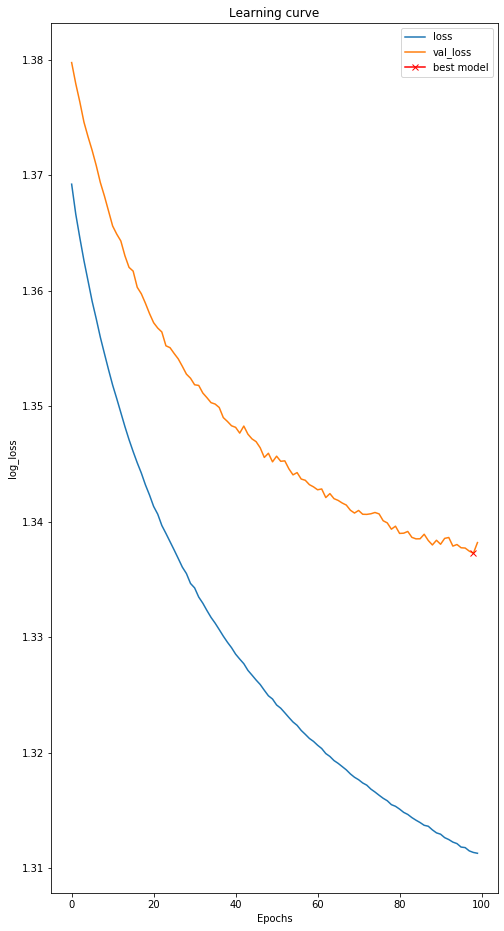

In [368]:
import matplotlib
from matplotlib import pyplot as plt

results=history

plt.figure(figsize=(8, 16))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();


In [ ]:
# beam search
# end of line character should be zeros
# dropout
# try GRU
# save best model



In [403]:
from keras import layers, models
from keras.layers import Dense, Input, LSTM,GRU

drp=0
model=models.Sequential()
model.add(LSTM(64, input_shape=(Tx, len(characters)),return_sequences=True,activation="softmax"))
model.add(Dense(len(characters),activation="softmax"))
model.summary()

Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_31 (LSTM)               (None, 15, 64)            27392     
_________________________________________________________________
dense_29 (Dense)             (None, 15, 42)            2730      
Total params: 30,122
Trainable params: 30,122
Non-trainable params: 0
_________________________________________________________________


In [405]:
np.sum(model.predict(Xf[2:3,:,:]), axis=2)

array([[1.0000001 , 0.99999994, 1.0000001 , 1.        , 0.99999994,
        1.        , 0.9999999 , 1.        , 0.99999994, 1.        ,
        1.        , 0.9999999 , 0.99999994, 0.99999994, 1.        ]],
      dtype=float32)

In [390]:
model.predict(Xf[:1,:,:])

array([[[0.00751082, 0.00771122, 0.00736352, 0.00742367, 0.00828375,
         0.00764484, 0.00781036, 0.00792186, 0.00830439, 0.00748659,
         0.00785631, 0.00797882, 0.00748226, 0.00832559, 0.00816992,
         0.00774464, 0.00837419, 0.00826431, 0.00754519, 0.00766723,
         0.00760604, 0.00810976, 0.0081093 , 0.00816004, 0.00828095,
         0.00825982, 0.00789951, 0.00796695, 0.0082077 , 0.00804529,
         0.00817657, 0.00752608, 0.0077254 , 0.00817136, 0.00825257,
         0.00773064, 0.00800089, 0.00743151, 0.00725482, 0.00816547,
         0.00792588, 0.00814968, 0.00771759, 0.00809409, 0.00802816,
         0.00765526, 0.00779734, 0.0077412 , 0.00772986, 0.0075444 ,
         0.00780758, 0.00788464, 0.00762915, 0.00737183, 0.00761693,
         0.00745591, 0.00751873, 0.00830413, 0.00732688, 0.00764269,
         0.0083167 , 0.00755099, 0.00822983, 0.00765413],
        [0.00826527, 0.00766256, 0.00776304, 0.00762692, 0.00736928,
         0.00770531, 0.00731369, 0.0075045 , 